In [12]:
import geopandas as gpd

# Read the shapefile
gdf = gpd.read_file("../data/0/evacuation.shp")

# Print the first few rows of the GeoDataFrame
print(gdf.head())

                             geometry
0  POINT Z (587469.083 2327813.818 0)
1  POINT Z (587469.083 2327813.818 0)
2  POINT Z (587616.766 2327612.655 0)
3  POINT Z (588318.284 2326918.048 0)


In [1]:
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd

# Load GTFS stops data
stops_df = pd.read_csv("../data/1/stops.txt")

# Create GeoDataFrame with point geometries
cleaned_df = pd.DataFrame({'name': stops_df['stop_id']})
stops_gdf = gpd.GeoDataFrame(
    cleaned_df, geometry=gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat, z=0)
)
stops_gdf.set_crs(epsg=4326, inplace=True)

# # Save as Shapefile
stops_gdf.to_file("../exports/1/stops.shp")
# print("stops_gdf")
print(stops_gdf.head())


   name                        geometry
0  2454  POINT Z (-95.81403 36.08521 0)
1  3123  POINT Z (-95.88866 36.11397 0)
2  3142  POINT Z (-95.88898 36.11533 0)
3  4120   POINT Z (-95.85114 36.0532 0)
4  4131  POINT Z (-95.79763 36.01656 0)
              name
count  1521.000000
mean   7609.480605
std     730.416894
min    2454.000000
25%    7198.000000
50%    7651.000000
75%    8093.000000
max    8981.000000


In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString

# Load GTFS shapes data
shapes_df = pd.read_csv("../data/1/shapes.txt")

# Group by shape_id to create lines
shapes = shapes_df.groupby("shape_id").apply(
    lambda x: LineString(zip(x["shape_pt_lon"], x["shape_pt_lat"]))
)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(shapes, columns=["geometry"])
gdf.set_crs(epsg=4326, inplace=True)  # Set WGS 84 coordinate system

# Save as Shapefile
# gdf.to_file("routes.shp")
gdf.head()

print(shapes_df['shape_pt_lat'].describe())
print(shapes_df['shape_pt_lon'].describe())

count    22493.000000
mean        36.106332
std          0.053794
min         35.990318
25%         36.060800
50%         36.110210
75%         36.148069
max         36.249550
Name: shape_pt_lat, dtype: float64
count    22493.000000
mean       -95.923223
std          0.067852
min        -96.120190
25%        -95.975870
50%        -95.938670
75%        -95.864550
max        -95.779550
Name: shape_pt_lon, dtype: float64


/var/folders/wy/19hmjgc57ssck07jnj6pz2x00000gn/T/ipykernel_94269/1474091704.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shapes = shapes_df.groupby("shape_id").apply(


In [15]:
import numpy as np

def line_transform_matrix(x1, y1, x2, y2, x3, y3, x4, y4):
    # Compute direction vectors
    vec_A = np.array([x2 - x1, y2 - y1])
    vec_B = np.array([x4 - x3, y4 - y3])
    
    # Compute scale factor
    len_A = np.linalg.norm(vec_A)
    len_B = np.linalg.norm(vec_B)
    scale = len_B / len_A if len_A != 0 else 1
    
    # Compute rotation angle
    angle_A = np.arctan2(vec_A[1], vec_A[0])
    angle_B = np.arctan2(vec_B[1], vec_B[0])
    theta = angle_B - angle_A
    
    # Compute transformation matrix components
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)
    rotation_matrix = np.array([[cos_theta, -sin_theta], [sin_theta, cos_theta]])
    scale_matrix = scale * rotation_matrix
    
    # Compute translation
    transformed_origin_A = scale_matrix @ np.array([x1, y1])
    translation = np.array([x3, y3]) - transformed_origin_A
    
    # Construct affine transformation matrix
    T = np.array([
        [scale_matrix[0, 0], scale_matrix[0, 1], translation[0]],
        [scale_matrix[1, 0], scale_matrix[1, 1], translation[1]],
        [0, 0, 1]
    ])
    
    return T

def apply_transform(T, x, y):
    """ Apply the transformation matrix T to a point (x, y). """
    point = np.array([x, y, 1])  # Homogeneous coordinates
    transformed_point = T @ point
    return transformed_point[:2]  # Return only x' and y'

# Example Usage
x1, y1, x2, y2 = -95.814026, 36.08521, -95.888656, 36.113966  # Line A
x3, y3, x4, y4 = 27913.23122659, 19078.33425973, 21286.54427249, 15690.39059779  # Line B
T = line_transform_matrix(x1, y1, x2, y2, x3, y3, x4, y4)

# Transforming another point (5, 5)
new_x, new_y = apply_transform(T, -95.814026, 36.08521)
print(f"Transformed point: ({new_x:.2f}, {new_y:.2f})")


Transformed point: (27913.23, 19078.33)


In [31]:
lon1, lat1, lon2, lat2 = -95.814026, 36.08521, -95.888656, 36.113966  # Line A
gama_x1, gama_y1, gama_x2, gama_y2 = 27913.23122659, 19078.33425973, 21286.54427249, 15690.39059779  # Line B

# translate_x, translate_y = x3 - x1, y3 - y1
# scale_x, scale_y = (x4 - x3) / (x2 - x1), (y4 - y3) / (y2 - y1)
# translate_x, translate_y = 0, 0
# scale_x, scale_y = 1, 1

import pyproj
from affine import Affine

# Define source and target coordinate systems
# Replace 'EPSG:4326' with the actual CRS of your shapefile
src_crs = pyproj.CRS("EPSG:4326")  # WGS84 (Latitude, Longitude)
target_crs = pyproj.CRS("EPSG:4326")  # Web Mercator (example)

# Transformer to convert (lon, lat) to projected coordinates
projector = pyproj.Transformer.from_crs(src_crs, target_crs, always_xy=True)


# Convert geographic coordinates to projected coordinates
proj_x1, proj_y1 = projector.transform(lon1, lat1)
proj_x2, proj_y2 = projector.transform(lon2, lat2)

# Compute scale factors
scale_x = (gama_x2 - gama_x1) / (proj_x2 - proj_x1)
scale_y = (gama_y2 - gama_y1) / (proj_y2 - proj_y1)

# Compute translation offsets
translate_x = gama_x1 - scale_x * proj_x1
translate_y = gama_y1 - scale_y * proj_y1

print(f"Scale X: {scale_x}, Scale Y: {scale_y}")
print(f"Translate X: {translate_x}, Translate Y: {translate_y}")

# # Define the affine transformation (adjust based on your GAMA environment)
# # These values should be extracted from GAMA or calculated from your shapefile's bounding box.
# # Example transformation: scaling and translating coordinates
# scale_x, scale_y = 0.01, -0.01  # Adjust scales according to GAMA dimension
# translate_x, translate_y = 100, 200  # Adjust translation

affine_transform = Affine(scale_x, 0, translate_x, 0, scale_y, translate_y)

def convert_to_gama_coords(lon, lat):
    """Convert (longitude, latitude) to GAMA coordinate system."""
    x_proj, y_proj = projector.transform(lon, lat)  # Convert to projected CRS
    x_gama, y_gama = affine_transform * (x_proj, y_proj)  # Apply affine transformation
    return x_gama, y_gama

# Function to convert new (longitude, latitude) to GAMA coordinates
def convert_to_gama(lon, lat):
    x_proj, y_proj = projector.transform(lon, lat)
    print(x_proj, y_proj)
    x_gama = scale_x * x_proj + translate_x
    y_gama = scale_y * y_proj + translate_y
    return x_gama, y_gama

# Example usage
longitude, latitude = -95.814026, 36.08521
gama_x, gama_y = convert_to_gama_coords(longitude, latitude)
# gama_x, gama_y = convert_to_gama(longitude, latitude)
print(f"GAMA Coordinates: ({gama_x}, {gama_y})")


longitude, latitude = -95.94884, 36.02787
gama_x, gama_y = convert_to_gama_coords(longitude, latitude)
# gama_x, gama_y = convert_to_gama(longitude, latitude)
print(f"GAMA Coordinates: ({gama_x}, {gama_y})")


Scale X: 88793.87584215574, Scale Y: -117816.93079495907
Translate X: 8535611.959807672, Translate Y: 4270527.023551295
GAMA Coordinates: (27913.23122658953, 19078.334259729832)
GAMA Coordinates: (15942.573648804799, 25833.957071512006)


In [1]:
import pandas as pd

# Load GTFS stops data
trips_df = pd.read_csv("../data/1/trips.txt")

trips_df['service_id'].unique()	

array([1, 2, 9, 5])

# Population datta

In [6]:
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd
import geopandas as gpd

# Load the GeoPackage file
gdf = gpd.read_file("../../data/po_toulouse/toulouse_activities.gpkg")
gdf.set_crs(epsg=2154, inplace=True)  # Set the CRS to EPSG:2154 (Lambert-93)
gdf.to_crs(crs=4326, inplace=True)
gdf['lon'] = gdf.geometry.x
gdf['lat'] = gdf.geometry.y

print(gdf['lon'].describe())
print(gdf['lat'].describe())


# gdf.to_file("../../exports/3/toulouse_activities.geojson", driver='GeoJSON')



count    11896.000000
mean         1.563417
std          0.592846
min         -0.234779
25%          1.322584
50%          1.444969
75%          1.948113
max          3.233330
Name: lon, dtype: float64
count    11896.000000
mean        43.563492
std          0.288323
min         42.715074
25%         43.428795
50%         43.590543
75%         43.689498
max         44.364633
Name: lat, dtype: float64


In [4]:
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd
import geopandas as gpd

# Load the GeoPackage file
gdf = gpd.read_file("~/Downloads/riv_final_Project1.dbf")

print(gdf.head())

print(gdf['NAME'].unique())
print(gdf['CATEGORY'].unique())


# gdf.to_file("../exports/3/toulouse_commutes.shp")


         LENGTH  CATEGORY            NAME  ANL_RUNOFF  AN_RUN_MOU FLO_PATERN  \
0   5391.647315      MAIN       Wadi Awik    81500000           0   Seasonal   
1   6269.975960      MAIN   Nahr Ostouene    75000000    64000000  Permanent   
2   7163.777167      MAIN   Nahr Ostouene    75000000    64000000  Permanent   
3     21.429595  SUB-MAIN  Naher Ostouene    75000000    64000000  Permanent   
4  17375.290638      MAIN   Nahr El Kebir    95000000   184000000  Permanent   

                                            geometry  
0  LINESTRING (-882187.482 3930880.106, -882093.8...  
1  LINESTRING (-868262.419 3926147.164, -868166.3...  
2  LINESTRING (-873071.576 3928495.489, -873104.4...  
3  LINESTRING (-855496.004 3924106.331, -855485.7...  
4  MULTILINESTRING ((-846916.329 3933608.227, -84...  
['Wadi Awik' 'Nahr Ostouene' 'Naher Ostouene' 'Nahr El Kebir'
 'Nahr El Assi' 'Naher El Bared' 'Nahr El Bared' 'Nahr El Litani'
 'Naher El Litani' 'Nahr Zahrani' 'Nahr Sainik' 'Nahr Awali (

In [ ]:
import pandas as pd

df = pd.read_csv("~/Downloads/logs_result.csv")
df.head()

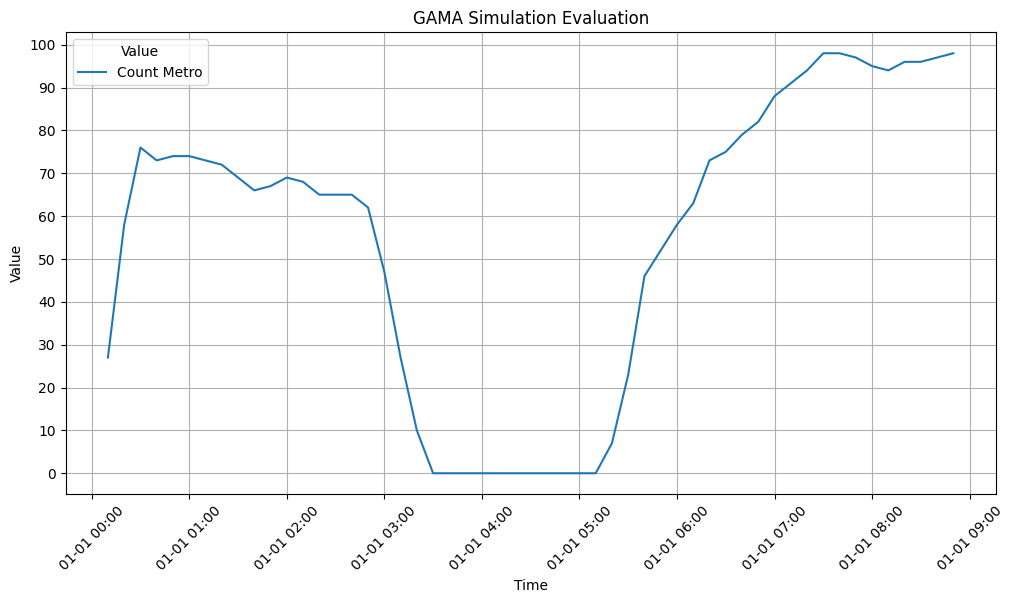

In [ ]:
# Draw GAMA simulation evaluation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv("../../GAMA/CityTransport/results/diff_arrival_time.csv")
df.head()

# Set the time column as the index
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)
# Plot 2 columns: max_early and max_late in the same chart, same axis use sns
plt.figure(figsize=(12, 6))
df = df[df["max_late"] > -86000]

sns.lineplot(data=df, x='time', y='max_early', label='Max Early')
sns.lineplot(data=df, x='time', y='max_late', label='Max Late')
sns.lineplot(data=df, x='time', y='mean_early', label='Mean Early')
sns.lineplot(data=df, x='time', y='mean_late', label='Mean Late')
# sns.lineplot(data=df, x='time', y='count_metro', label='Count Metro')
# format x-axis to mm-dd HH:MM
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.title('GAMA Simulation Evaluation')
plt.xlabel('Time')
plt.ylabel('Value')
# config y axis tick step every 10
plt.gca().yaxis.set_major_locator(plt.matplotlib.ticker.MultipleLocator(10))
plt.legend(title='Value')
plt.grid()
plt.show()


In [2]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

# Your documents and categories
documents = [
    {"text": "Python is a programming language", "category": "programming"},
    {"text": "Paris is the capital of France", "category": "geography"},
    {"text": "The Eiffel Tower is in Paris", "category": "geography"},
    {"text": "C++ is powerful for systems programming", "category": "programming"}
]

texts = [doc["text"] for doc in documents]
categories = [doc["category"] for doc in documents]

# Build vector index
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts, convert_to_numpy=True)

index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)


query = "What's a European city?"
query_embedding = model.encode([query], convert_to_numpy=True)

# Vector search
D, I = index.search(query_embedding, k=10)
print("Distances:", D)
print("Indices:", I)

# Filter by category
desired_category = "geography"
results = []
for idx in I[0]:
    if categories[idx] == desired_category:
        results.append(documents[idx]["text"])

print("Filtered results:", results)


Distances: [[1.2530128e+00 1.4477590e+00 1.7033445e+00 1.7929977e+00 3.4028235e+38
  3.4028235e+38 3.4028235e+38 3.4028235e+38 3.4028235e+38 3.4028235e+38]]
Indices: [[ 1  2  0  3 -1 -1 -1 -1 -1 -1]]
Filtered results: ['Paris is the capital of France', 'The Eiffel Tower is in Paris']


In [1]:
from pyproj import Transformer

transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")  # WGS84 -> Web Mercator
x, y = transformer.transform(21.03, 105.85)  # lat, lon
print(f"x: {x}, y: {y}")


x: 11783168.100468006, y: 2395456.1271036775


In [6]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Giả sử bạn có N đoạn văn
texts = [
    "Tôi thích học máy.",
    "Machine learning là sở thích của tôi.",
    "Hôm nay trời đẹp.",
    "Thời tiết hôm nay rất dễ chịu.",
    "Tôi yêu học sâu.",
    "Deep learning là lĩnh vực tôi quan tâm."
]

# 1. Sinh vector embedding
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts, convert_to_tensor=False)

# 2. Cluster các vector bằng DBSCAN theo cosine distance
clustering = DBSCAN(eps=0.4, min_samples=1, metric='cosine')
labels = clustering.fit_predict(embeddings)

# 3. Với mỗi cluster, chọn văn bản gần "trung tâm" nhất (đại diện cụm)
selected_texts = []
for cluster_id in set(labels):
    indices = [i for i, lbl in enumerate(labels) if lbl == cluster_id]
    cluster_vectors = [embeddings[i] for i in indices]
    similarity_matrix = cosine_similarity(cluster_vectors)
    avg_sim = similarity_matrix.mean(axis=1)
    best_idx = indices[int(np.argmax(avg_sim))]
    selected_texts.append(texts[best_idx])

print("Các đoạn văn tiêu biểu, loại bỏ trùng nghĩa:")
for t in selected_texts:
    print("-", t)


Các đoạn văn tiêu biểu, loại bỏ trùng nghĩa:
- Tôi yêu học sâu.
- Machine learning là sở thích của tôi.
- Hôm nay trời đẹp.


In [3]:
from scipy.sparse import coo_matrix
import json

# Example sparse matrix
sparse = coo_matrix([[0, 4, 1], [2, 0, 0], [0, 3, 0]])

# Convert to dictionary
sparse_dict = {
    "shape": sparse.shape,
    "data": sparse.data.tolist(),
    "row": sparse.row.tolist(),
    "col": sparse.col.tolist()
}

# # Save to JSON
# with open("sparse_matrix.json", "w") as f:
#     json.dump(sparse_dict, f)

print(sparse_dict)

{'shape': (3, 3), 'data': [4, 1, 2, 3], 'row': [0, 0, 1, 2], 'col': [1, 2, 0, 1]}
